# [Analyzing 1000+ Greek Wines With Python](https://tselai.com/greek-wines-analysis.html)

One of my most enjoyable guilty pleasures has always been [web scraping](https://en.wikipedia.org/wiki/Web_scraping).
Especially during the past year I have scraped countless websites, both for fun and profit.
From niche and mainstream e-shops to news outlets and literary blogs, it is amazing how much interesting and clean data one can get by using simple tools like `BeautifulSoup`- I won't even mention what a joy Chrome's Headless mode has been.

In this post I'll play with the data I scraped from a [Greek wine e-shop](http://www.houseofwine.gr/). In lieu of apology for sending a few more requests to their server I urge everyone browse through their catalog and maybe even buy a few bottles.

The scraper itself is fairly simple and can be found on my [GitHub page](https://github.com/Florents-Tselai/greek-wines-analysis). Here I'll focus on doing some quick exploratory analysis on the data I got (1125 unique labels) by using standard python packages.

The scraper itself exposes a fairly simple API. You request data for a given wine page and it returns a nice `dict` with the data, like this:

In [49]:
from houseofwine_gr import get

In [50]:
url='https://www.whisky.de/shop/Schottland/Single-Malt/Islay/Lagavulin-8-Jahre.html'

print(get(url))

{'ageable': False, 'name': 'Lagavulin 8 Jahre', 'price': None, 'drink_now': False, 'avg_rating_%': '', 'tags': [''], 'url': 'https://www.whisky.de/shop/Schottland/Single-Malt/Islay/Lagavulin-8-Jahre.html', 'year': None, 'n_votes': '', 'color': None, 'keep_2_3_years': False, 'description': '', 'alcohol_%': None}


We start by defining some `matplotlib` aesthetics.

In [51]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

plt.style.use('fivethirtyeight')

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Serif'
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.grid'] =False
plt.rcParams['figure.facecolor']='white'

We load a dump of the data produced by the `houseofwine_gr.dump` module. You can find the dataset in `.json, .csv and .xlsx` in the GitHub page as well.

In [52]:
import pandas as pd

df = pd.read_json('./data/whisky.json', encoding='utf-8')

Here's a view of the data we have.

In [53]:
df.head()

,alcohol_%,avg_rating_%,country,description,distillery,img,n_votes,name,price,taste_box_fruits,taste_box_gravy,taste_box_qualitiy,taste_box_sherry_port_barrel,taste_box_smoke_torf,taste_box_sweet,taste_box_total,url,whisky_type
0,52.4,NaN,Scotland,Dieser Imperial wurde vom unabhängigen Abfülle...,Signatory Vintage Scotch Whisky Co. Ltd. Pitlo...,https://www.whisky.de/shop/out/pictures/genera...,NaN,Imperial 19J-1995/2015,9790,46.0,70.0,72.0,13.0,6.0,70.0,66.0,https://www.whisky.de/shop/Schottland/Imperial...,[Single Malt Whisky]
1,45.0,4.0,Scotland,Sassicaia ist ein Rotwein aus der Toskana. Das...,Gordon & MacPhail Boroughbriggs Road Elgin Mor...,https://www.whisky.de/shop/out/pictures/genera...,1.0,Benromach Sassicaia Finish 2009/2017,5490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.whisky.de/shop/Schottland/Benromac...,[Single Malt Whisky]
2,60.0,3.6,Scotland,105 proof war das alte Maß für die Angabe des ...,Glenfarclas Distillery Ballindalloch Banffshir...,https://www.whisky.de/shop/out/pictures/genera...,61.0,Glenfarclas 105,3690,50.0,68.0,72.0,72.0,6.0,46.0,73.0,https://www.whisky.de/shop/Schottland/Glenfarc...,[Single Malt Whisky]
3,43.0,NaN,Scotland,In den 1960ern startete der unabhängige Abfüll...,Gordon & MacPhail Boroughbriggs Road Elgin Mor...,https://www.whisky.de/shop/out/pictures/genera...,NaN,Convalmore Conn. 1984/2011,49800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.whisky.de/shop/Schottland/Convalmo...,[Single Malt Whisky]
4,48.0,3.9,Scotland,Dieser 12-jährige Single Malt Whisky aus der A...,Aberlour Distillery Co. Ltd. Aberlour Banffshi...,https://www.whisky.de/shop/out/pictures/genera...,186.0,Aberlour Non Chill-Filtered mit 2 Gläsern 12 J...,4690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.whisky.de/shop/Schottland/Aberlour...,[Single Malt Whisky]


We replace empty strings with `np.nan` to make them easier to handle for `Pandas`

In [54]:
from numpy import nan
df = df.replace('', nan, regex=True)


We rename some column names containing special characters in order to use them as native `DataFrame` accessors.

In [55]:
df = df.rename(columns={'alcohol_%': 'alcohol', 'avg_rating_%': 'avg_rating'}, inplace=False)

We also assign appropriate types to the columns.

In [56]:
df['alcohol'] = df.alcohol.astype(float)
df['n_votes'] = df.n_votes.astype(int, errors='ignore')
df['price'] = df.price.astype(float) / 100
#df['year'] = df.year.astype(int, errors='ignore')

Let's check out the distribution of some straightforward metrics for each wine.

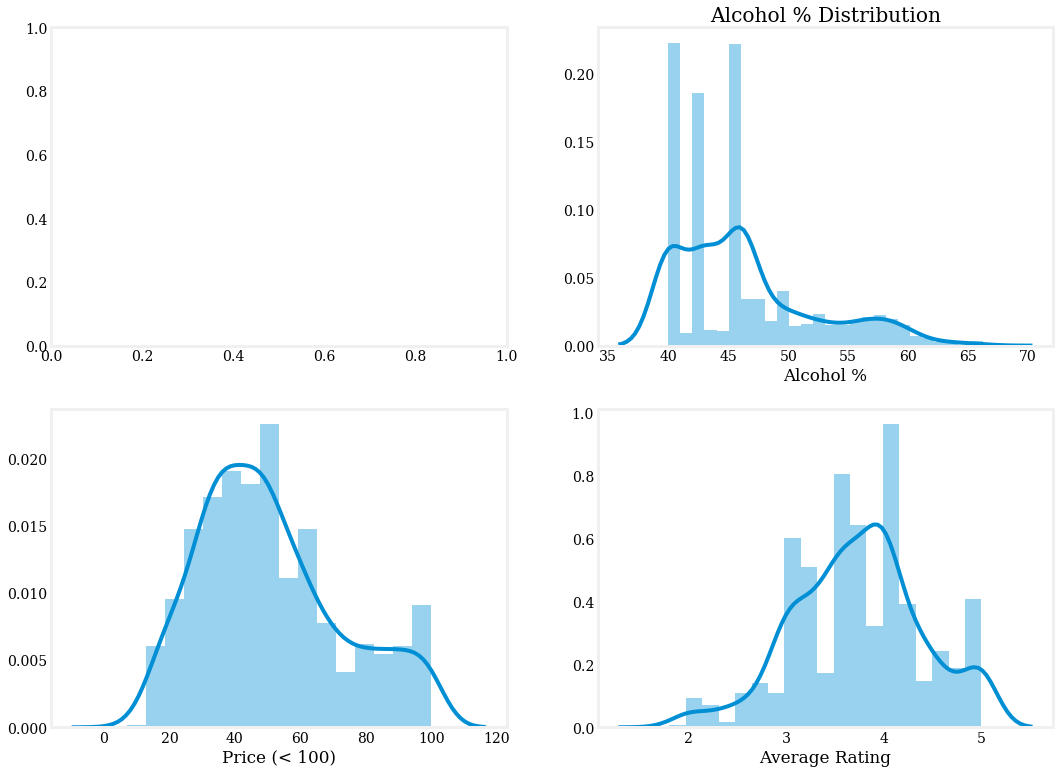

In [66]:
fig, ((ax1, ax2), 
      (ax3, ax4)
     ) = plt.subplots(ncols=2, nrows=2, figsize=(16,12))

sns.distplot(df[df.alcohol < 100].alcohol.dropna(), ax=ax2)
ax2.set(xlabel='Alcohol %', title='Alcohol % Distribution');

sns.distplot(df[df.price < 100].price.dropna(), ax=ax3)
ax3.set(xlabel='Price (< 100)')

sns.distplot(df.avg_rating.dropna(), ax=ax4)
ax4.set(xlabel='Average Rating');

An immediate observation is the almost-normal distribution one sees for the `Average Rating` column with a high mean of 85+.
[Kroutoner on Reddit](https://www.reddit.com/r/datascience/comments/7e0mw5/analyzing_1000_greek_wines_with_python/dq1x4ls/) explains why this happens (and also corrects a previous mistake of mine):

*The typical wine rating scale is on 50-100, not 0-100. So what looked like was a distribution with only half support is actually a nearly fully supported distribution with slight left skew. Further, there's a huge difference culturally between wines with ratings below and above 90, with wines receiving a rating above 90 generally being considered significantly better and also selling significantly better. This cultural fact completely changes the reasonable interpretation of the data. Most wines are rated as ok and only a small portion being rated as really good.*